# AAA Project : FC 24

This project is at the heart of the "Algorithms and Machine Learning" course at IMT Atlantique (Nantes, France). We have chosen to attempt to develop a machine learning model capable of predicting a player's rating based on their FC 24 card. This problem is a regression task that will use supervised machine learning and batch learning.

- Dataset : https://www.kaggle.com/datasets/nyagami/fc-24-players-database-and-stats-from-easports (There are some usefull works made in Kaggle we could use, especially during the data exploration / visualization)
- A usefull work we read before doing this project : https://towardsdatascience.com/fifa-ultimate-team-rating-prediction-machine-learning-project-3a02767fcb38 


Here some common import that could be usefull for the project :

In [1]:
# Scikit-Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## DATA

### Data exploration

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/elouanzer/AAAproject_FC24/main/all_players.csv')

In [11]:
df.head()

Unnamed: 0             Name     Nation             Club Position  Age  \
0           0    Kylian Mbappé     France         Paris SG       ST   24   
1           1   Erling Haaland     Norway  Manchester City       ST   23   
2           2  Kevin De Bruyne    Belgium  Manchester City       CM   32   
3           3     Lionel Messi  Argentina   Inter Miami CF       CF   36   
4           4    Karim Benzema     France       Al Ittihad       CF   35   

   Overall  Pace  Shooting  Passing  ...  Strength  Aggression  Att work rate  \
0       91    97        90       80  ...        77          64           High   
1       91    89        93       66  ...        93          87           High   
2       91    72        88       94  ...        74          75           High   
3       90    80        87       90  ...        68          44            Low   
4       90    79        88       83  ...        82          63         Medium   

   Def work rate  Preferred foot  Weak foot  Skill moves  \
0            Low           Right          4            5   
1         Medium            Left          3            3   
2         Medium           Right          5            4   
3            Low            Left          4            4   
4         Medium           Right          4            4   

                                                 URL  Gender  GK  
0  https://www.ea.com/games/ea-sports-fc/ratings/...       M NaN  
1  https://www.ea.com/games/ea-sports-fc/ratings/...       M NaN  
2  https://www.ea.com/games/ea-sports-fc/ratings/...       M NaN  
3  https://www.ea.com/games/ea-sports-fc/ratings/...       M NaN  
4  https://www.ea.com/games/ea-sports-fc/ratings/...       M NaN  

[5 rows x 47 columns]

'URL', 'Name' and 'Unnamed: 0' seem to be completly useless so we won't keep them.

In [3]:
df = df.drop(['Name', 'URL', 'Unnamed: 0'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17326 entries, 0 to 17325
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nation          17326 non-null  object 
 1   Club            17326 non-null  object 
 2   Position        17326 non-null  object 
 3   Age             17326 non-null  int64  
 4   Overall         17326 non-null  int64  
 5   Pace            17326 non-null  int64  
 6   Shooting        17326 non-null  int64  
 7   Passing         17326 non-null  int64  
 8   Dribbling       17326 non-null  int64  
 9   Defending       17326 non-null  int64  
 10  Physicality     17326 non-null  int64  
 11  Acceleration    17326 non-null  int64  
 12  Sprint          17326 non-null  int64  
 13  Positioning     17326 non-null  int64  
 14  Finishing       17326 non-null  int64  
 15  Shot            17326 non-null  int64  
 16  Long            17326 non-null  int64  
 17  Volleys         17326 non-null 

The data set has about 17k rows and 46 columns. It is quite dense and clean, which seems to be good to train our model. There are both numerical and categorical features.

However, there are too many missing values in the 'GK' features. We will see how to manage them after. Now, we want to see what are the different categories inside our categorical features to a have a first idea for encoding them.

In [7]:
excluded_columns = ['Nation', 'Club'] #not shown because of their number, we will deal with them after
data_object = df.select_dtypes('object')

print("The different categories among the non numerical features : \n")

for col in data_object.columns.difference(excluded_columns):
  print(f'{col.ljust(30, "-")} {df[col].unique()}')

The different categories among the non numerical features : 

Att work rate----------------- ['High' 'Low' 'Medium']
Def work rate----------------- ['Low' 'Medium' 'High']
Gender------------------------ ['M' 'F']
Position---------------------- ['ST' 'CM' 'CF' 'GK' 'RW' 'CB' 'LW' 'CDM' 'CAM' 'RM' 'LB' 'RB' 'LM' 'LWB'
 'RWB']
Preferred foot---------------- ['Right' 'Left']


Usual encoders should be fine for these features.

Now let's see how each variable looks like:

In [8]:
df.describe()

Age       Overall          Pace      Shooting       Passing  \
count  17326.000000  17326.000000  17326.000000  17326.000000  17326.000000   
mean      25.781658     66.980723     68.286448     54.803763     59.261284   
std        4.655255      6.981987     10.657137     13.872357      9.776640   
min       17.000000     47.000000     27.000000     19.000000     25.000000   
25%       22.000000     63.000000     62.000000     45.000000     53.000000   
50%       25.000000     67.000000     69.000000     57.000000     60.000000   
75%       29.000000     71.000000     76.000000     65.000000     66.000000   
max       43.000000     91.000000     97.000000     93.000000     94.000000   

          Dribbling     Defending   Physicality  Acceleration        Sprint  \
count  17326.000000  17326.000000  17326.000000  17326.000000  17326.000000   
mean      56.852822     51.510216     65.663858     64.844049     65.043634   
std       19.041291     16.439490      9.485501     15.319163     15.111650   
min        5.000000     15.000000     29.000000     14.000000     15.000000   
25%       52.000000     37.000000     60.000000     57.000000     58.000000   
50%       62.000000     55.000000     67.000000     68.000000     68.000000   
75%       69.000000     65.000000     73.000000     75.000000     75.000000   
max       96.000000     91.000000     90.000000     97.000000     97.000000   

       ...           Def      Standing       Sliding       Jumping  \
count  ...  17326.000000  17326.000000  17326.000000  17326.000000   
mean   ...     47.898361     49.738255     47.244661     66.759206   
std    ...     20.692083     21.309042     20.771639     11.687863   
min    ...      4.000000      8.000000      7.000000     27.000000   
25%    ...     31.000000     30.000000     28.000000     59.000000   
50%    ...     54.000000     58.000000     54.000000     68.000000   
75%    ...     65.000000     67.000000     64.000000     75.000000   
max    ...     92.000000     92.000000     90.000000     95.000000   

            Stamina      Strength    Aggression     Weak foot   Skill moves  \
count  17326.000000  17326.000000  17326.000000  17326.000000  17326.000000   
mean      63.733176     65.608623     56.614799      2.949786      2.419081   
std       16.440153     12.496360     16.892850      0.679713      0.794500   
min       15.000000     22.000000     11.000000      1.000000      1.000000   
25%       57.000000     58.000000     46.000000      3.000000      2.000000   
50%       67.000000     67.000000     60.000000      3.000000      2.000000   
75%       75.000000     74.000000     69.000000      3.000000      3.000000   
max       95.000000     96.000000     95.000000      5.000000      5.000000   

                GK  
count  1952.000000  
mean     66.867316  
std       8.010265  
min      46.000000  
25%      61.000000  
50%      67.000000  
75%      72.000000  
max      93.000000  

[8 rows x 37 columns]

All the features may follow a similar distribution (every max higher than 90, every mean around 50-60, etc). To be sure, we can plot bar charts.

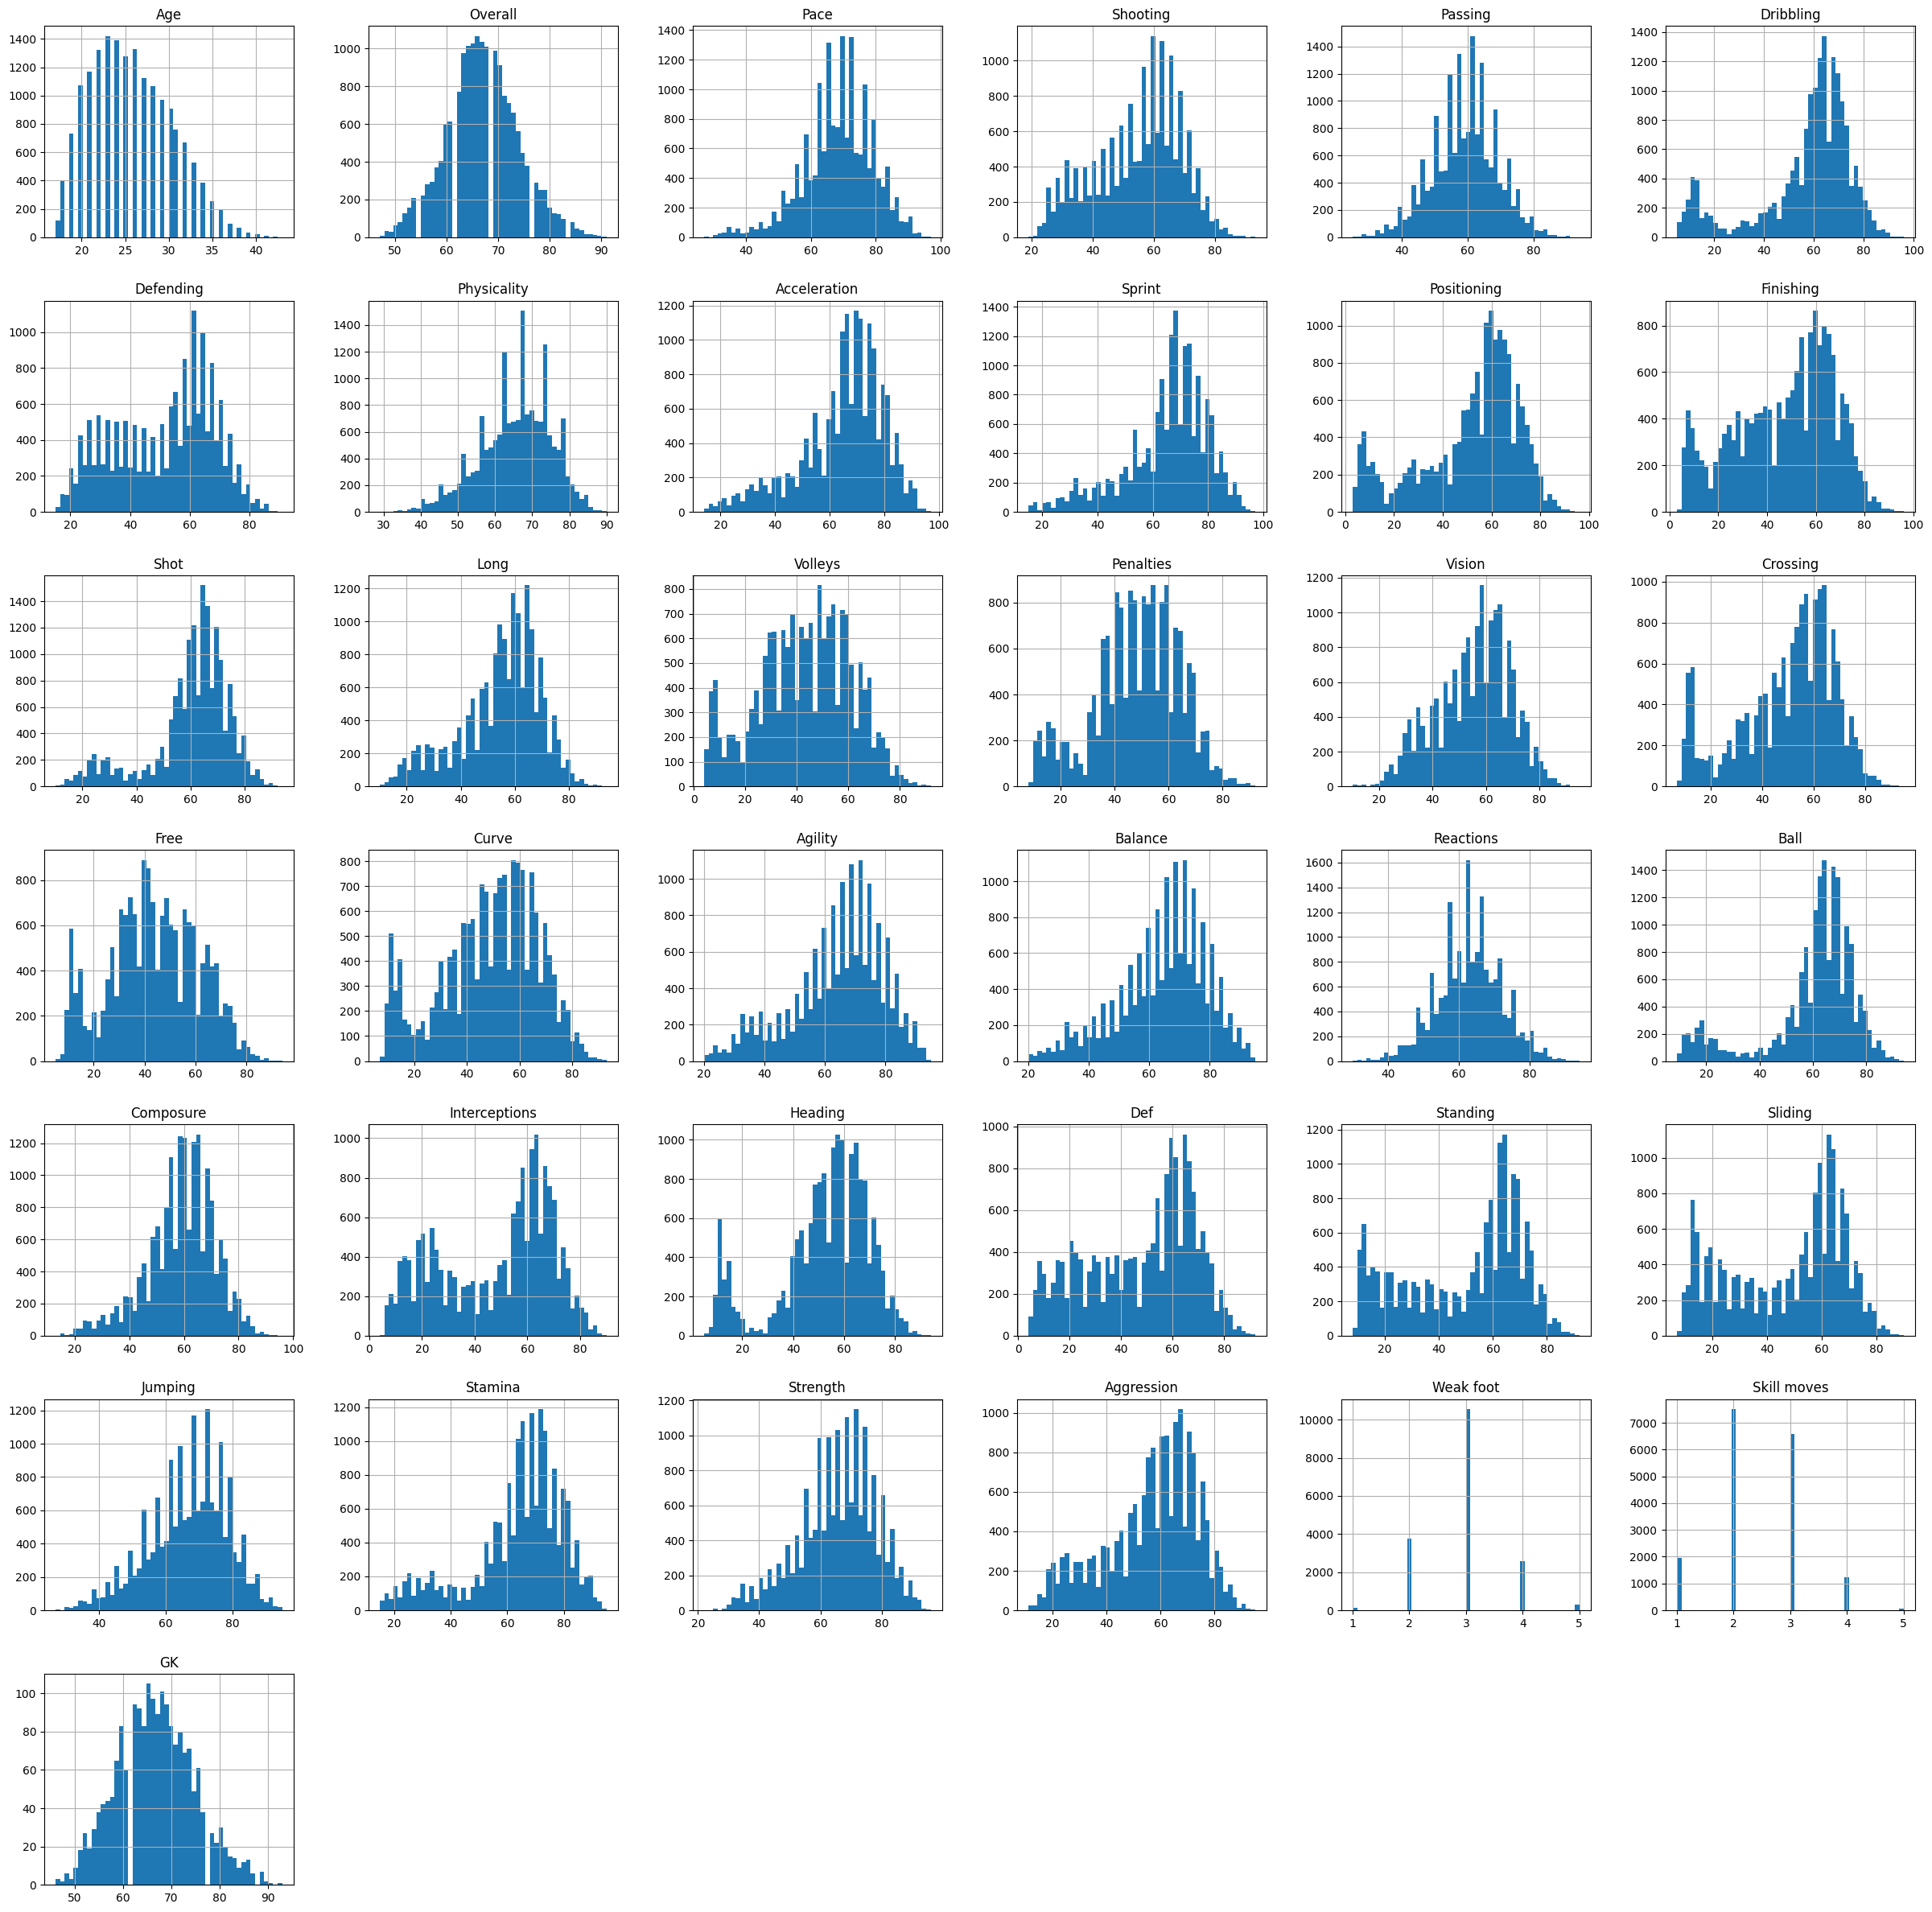

In [115]:
df.hist(bins=50, figsize=(30,30))
plt.show()

A few comments about the data set :

- every numerical features are between 0 and 100, except 'Weak foot' and 'Skill moves', which are integers between 0 and 5 (It would be a good idea to scale them at the same level), and 'Age'.
- some columns (including the label) such as 'Reactions' seems to follow a normal distribution.
- a lot of features seem to follow a "reverse chi 2 distribution" (slowly increase then skyrocket to reach a peak and then plummet) 

**'GK'**

Let's see if the 'GK' features is only for goal keeper and if only goal keepers have a value in this feature (it could represent the goal keeper skills for example):

In [116]:
df[df['GK'].notna()].equals(df[df['Position'] == 'GK'])

True

Our theory is true (and makes sense). We could remove it, but, as we can see below, 'GK' and 'Overall' are strongly correlated (we will study correlation with all the data set later).

0.9626972134083337


<Figure size 640x480 with 0 Axes>

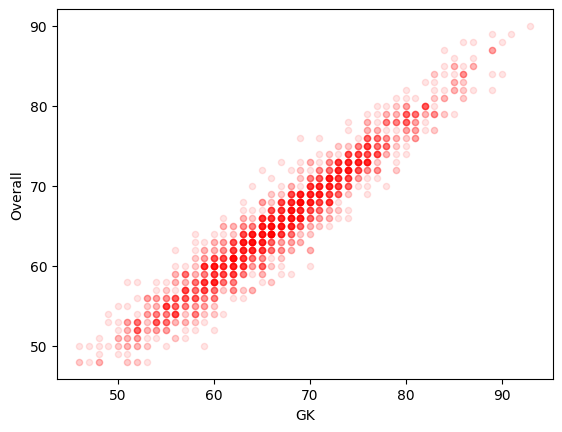

In [10]:
print(df['Overall'].corr(df['GK']))

plt.figure()
df.plot(kind='scatter', x='GK', y='Overall', alpha=0.1, color='red')
plt.show()

Keeping this information could be interesting so we should try to fill it to eliminate the missing values. The question is the following: which value sould we chose to fill this column?

The relationship between 'GK' and 'Overall' seems to be linear, so we may try a linear regression as our first estimator. If we want this value to be ignored in a such model, we will try to fill the column with zeros. This value is also interesting for other models like DecisionTree (min('GK') = 46 > 0).

In [4]:
#df = df.drop(['GK'], axis=1)
df = df.fillna(value={'GK':0})

**Position**

Let's plot a pairplot of some variables depending on the player's position. For more clarity, we will regroup defender, midfielder, goal keeper and attacker (3 categories instead of 15 found earlier).

Just a reminder : ['ST' 'CM' 'CF' 'GK' 'RW' 'CB' 'LW' 'CDM' 'CAM' 'RM' 'LB' 'RB' 'LM' 'LWB' 'RWB']

In [10]:
df_copy = df.copy()

def apply_position(position):
    if position in ['ST', 'CF', 'RW', 'LW']:
        return 'Attacker'
    elif position in ['CM', 'RM', 'LM', 'CDM', 'CAM']:
        return 'Midfielder'
    elif position == 'GK':
        return 'Goal Keeper'
    else:
        return 'Defender'

df_copy['Position 2.0'] = df_copy['Position'].apply(apply_position)
df_copy = df_copy.drop(['Position'], axis=1)

In [11]:
df_copy['Position 2.0'].value_counts()

Position 2.0
Midfielder     6262
Defender       5866
Attacker       3246
Goal Keeper    1952
Name: count, dtype: int64

These values could help us to understand the following pairplot.

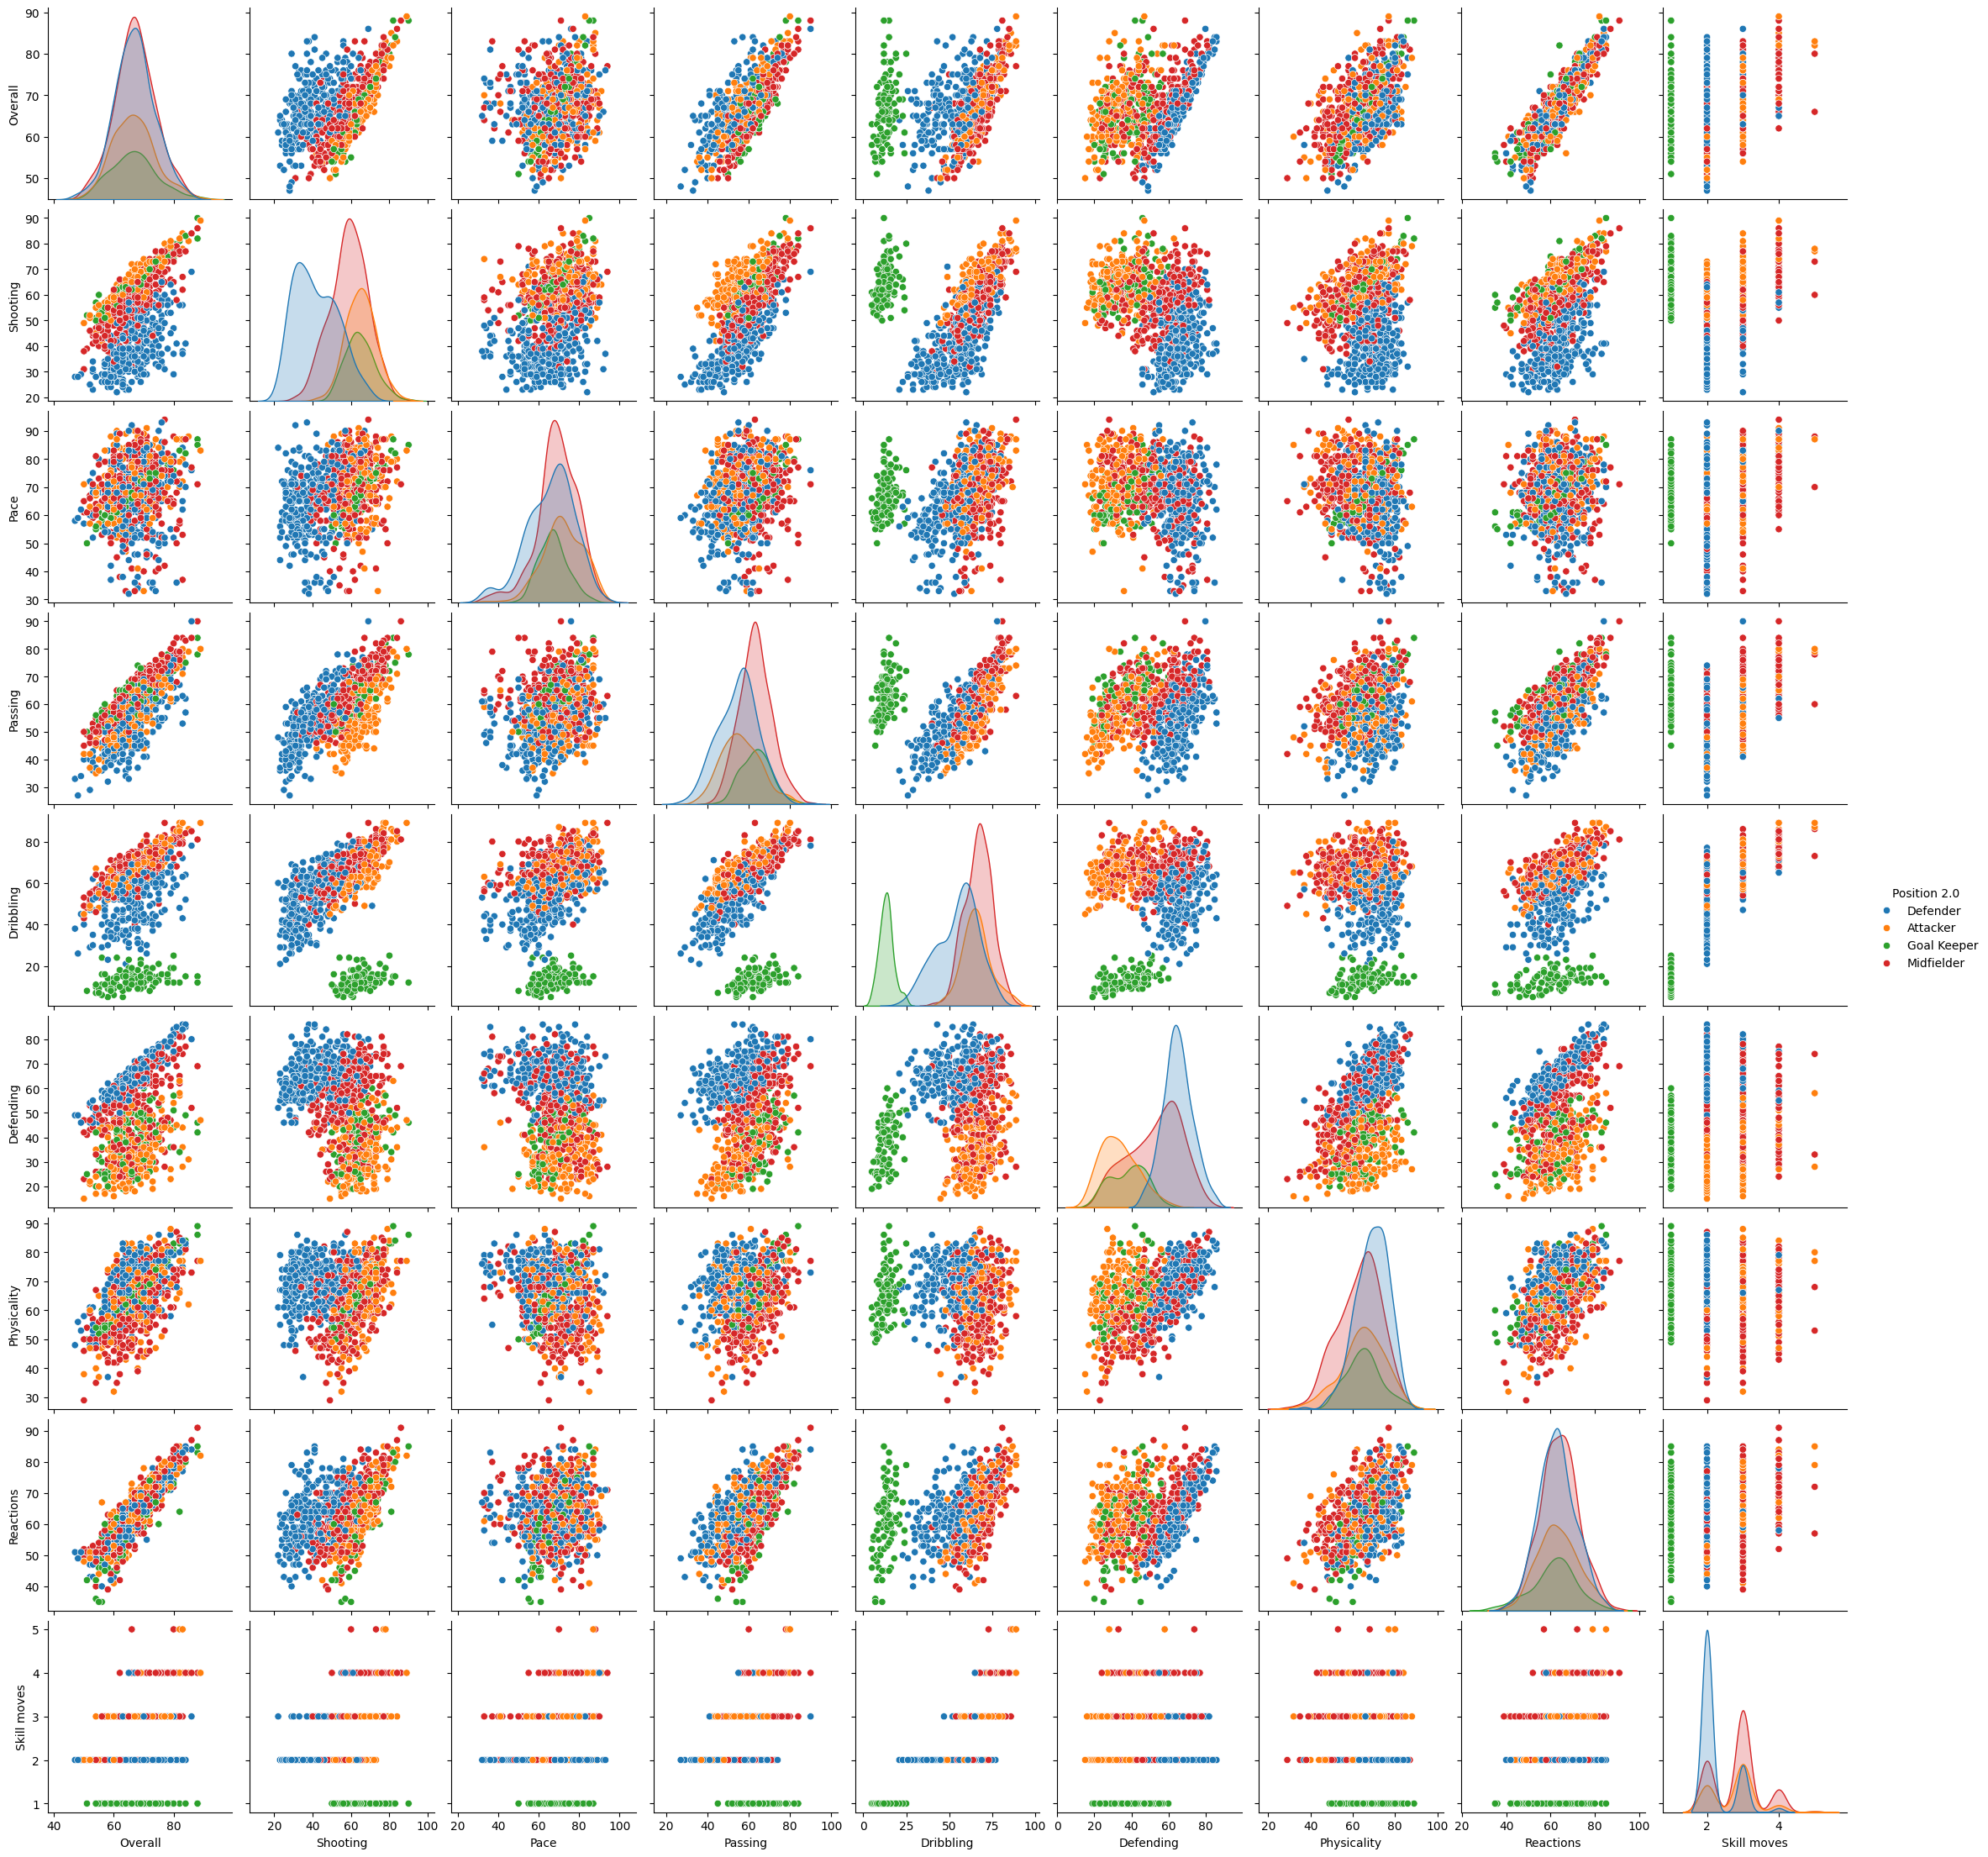

In [12]:
features = ['Overall', 'Shooting', 'Pace', 'Passing', 'Dribbling', 'Position 2.0', 'Defending', 
            'Physicality', 'Reactions', 'Skill moves']

sns.pairplot(df_copy[features].sample(1000), hue='Position 2.0')

What we can see in this figure : 
- our target seems to follow the same distribution for every position (regarding Position 2.0). Some peaks are higher than other one, but this could be explained by the fact that thoses positions are not equally distributed.
- this figure could be interesting if we wanted to guess the position thanks to the statistics (goal keepers seem to be really very bad dribblers, defenders seem to be very bad shooters, etc).

In a nutshell, this plot is very usefull for a classification problem but for our problem, it is not very interesting.

**Clubs and Nations**

We can try to plot the distribution of the categorical features to see if we can get some insights.

In [15]:
def plot_distribution(s, n) :
    counts = df[s].value_counts().head(n)
    plt.figure(figsize=(10,3))
    sns.barplot(x = counts.index, y = counts.values)
    plt.title(s+' Distribution')
    plt.xlabel(s)
    plt.xticks(rotation = 90)
    plt.ylabel('Frequency')
    plt.show()

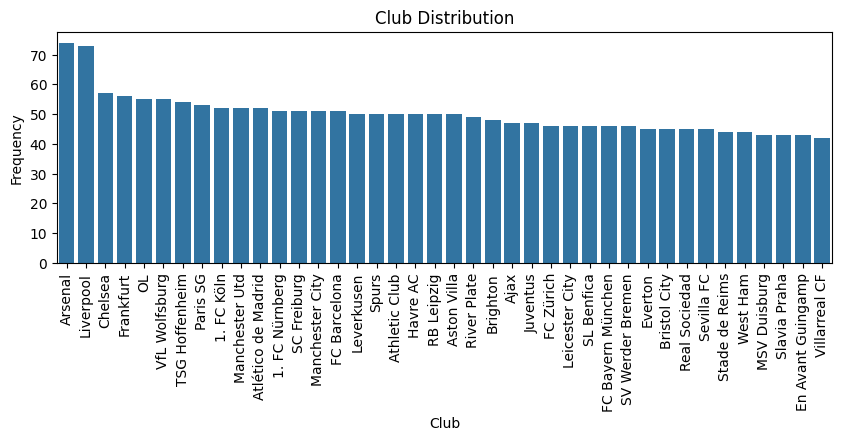

In [16]:
plot_distribution('Club', 40)

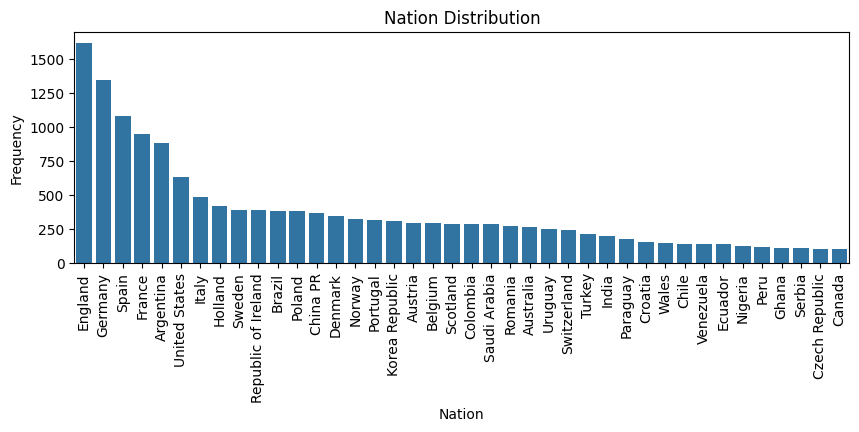

In [17]:
plot_distribution('Nation', 40)

In [94]:
print("There are", df['Club'].nunique(), "clubs.")
print("There are ", df['Nation'].nunique(), "nations.")

There are 676 clubs.
There are  155 nations.


From these, it is going to be complicated to transform this data into numerical data because: 
- if we use a OneHotEncoder, we will create too many columns in our dataset (hundreds of nations and clubs) which will increase the calculation time.
- if we use a OrdinalEncoder, we will lose the information given through these features (which could be very interesting in our opinion). For example, if OL is transformed into 500 and OM into 1, it would mean that OL >> OM, which is obviously false.

We must find a solution between these 2 ends. Our idea is to split the clubs / nations into level groups. With this, we try to keep most of the information given through the features. To do those groups, we can refer to several ranking on internet (UEFA, FIFA, ...).

In [5]:
group_1_clubs = ['Manchester City', 'Paris SG', 'FC Bayern München', 'Real Madrid', 'Liverpool']
group_2_clubs = ['FC Barcelona', 'Inter', 'Chelsea', 'RB Leipzig', 'Manchester Utd', 'Roma FC', 
                 'Sevilla FC', 'Juventus', 'Borussia Dortmund', 'Atlético de Madrid', 'Napoli FC',
                 'Leverkusen', 'Villarreal CF', 'SL Benfica', 'FC Porto', 'Ajax', 'Bergamo Calcio',
                 'Shakhtardonetsk', 'Frankfurt', 'Arsenal']
#UEFA ranking

def apply_clubs(club):
    if club in group_1_clubs:
        return 2
    elif club in group_2_clubs:
        return 1
    else:
        return 0

df['Top Clubs'] = df['Club'].apply(apply_clubs)
df = df.drop(['Club'], axis=1)

In [6]:
top_nations = ['France', 'Argentina', 'Brazil', 'England', 'Belgium', 'Portugal', 'Holland',
               'Spain', 'Italy', 'Croatia']
#FIFA ranking


def apply_nations(nation):
    if nation in top_nations:
        return 1
    else:
        return 0

df['Top Nation'] = df['Nation'].apply(apply_nations)
df = df.drop(['Nation'], axis=1)

We can take a loot at the data now: 

In [7]:
df.head(10)

Position  Age  Overall  Pace  Shooting  Passing  Dribbling  Defending  \
0       ST   24       91    97        90       80         93         36   
1       ST   23       91    89        93       66         79         45   
2       CM   32       91    72        88       94         86         65   
3       CF   36       90    80        87       90         96         33   
4       CF   35       90    79        88       83         87         39   
5       GK   31       90    85        89       76         13         46   
6       ST   30       90    69        93       84         82         49   
7       ST   35       90    75        91       80         86         44   
8       RW   31       89    89        87       81         88         45   
9       CB   26       89    62        39       66         64         89   

   Physicality  Acceleration  ...  Aggression  Att work rate  Def work rate  \
0           78            97  ...          64           High            Low   
1           88            82  ...          87           High         Medium   
2           78            72  ...          75           High         Medium   
3           64            87  ...          44            Low            Low   
4           78            78  ...          63         Medium         Medium   
5           90            42  ...          23         Medium         Medium   
6           83            67  ...          80           High           High   
7           84            76  ...          81           High         Medium   
8           76            89  ...          63           High         Medium   
9           87            54  ...          93         Medium           High   

   Preferred foot  Weak foot  Skill moves  Gender    GK  Top Clubs  Top Nation  
0           Right          4            5       M   0.0          2           1  
1            Left          3            3       M   0.0          2           0  
2           Right          5            4       M   0.0          2           1  
3            Left          4            4       M   0.0          0           1  
4           Right          4            4       M   0.0          0           1  
5            Left          3            1       M  93.0          2           1  
6           Right          5            3       M   0.0          2           1  
7           Right          4            4       M   0.0          1           0  
8            Left          3            4       M   0.0          2           0  
9           Right          4            2       M   0.0          2           1  

[10 rows x 44 columns]

In [8]:
df['Top Clubs'].value_counts()

Top Clubs
0    16243
1      829
2      254
Name: count, dtype: int64

A lot of zeros, could be useless but let's try anyway.

In [10]:
df['Top Nation'].value_counts()

Top Nation
0    10732
1     6594
Name: count, dtype: int64

We actually see the modifications made on the clubs, the nations and the goal keepers.

**Other categorical features**

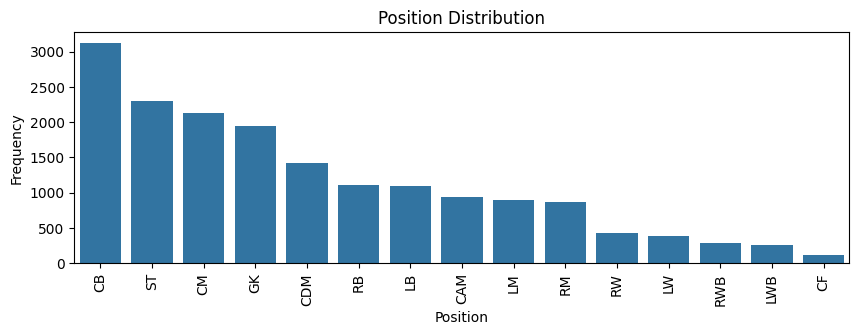

In [18]:
plot_distribution('Position', 20)

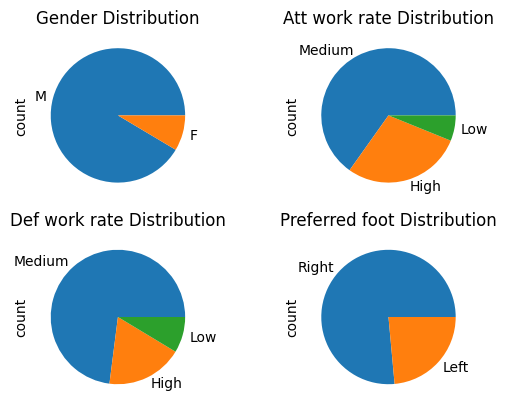

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

L = [('Gender',ax1), 
     ('Att work rate', ax2), 
     ('Def work rate', ax3), 
     ('Preferred foot', ax4)]

for feature, ax in L:
    df[feature].value_counts().plot.pie(ax=ax)
    ax.set_title(feature+' Distribution')

We can not learn much from this, except that these 5 features above are not equitably distributed.

### Looking for correlations

Let's focus now on corelation relationships.

In [8]:
corr_matrix = df.select_dtypes(['float64', 'int64']).corr()

<Figure size 800x800 with 0 Axes>

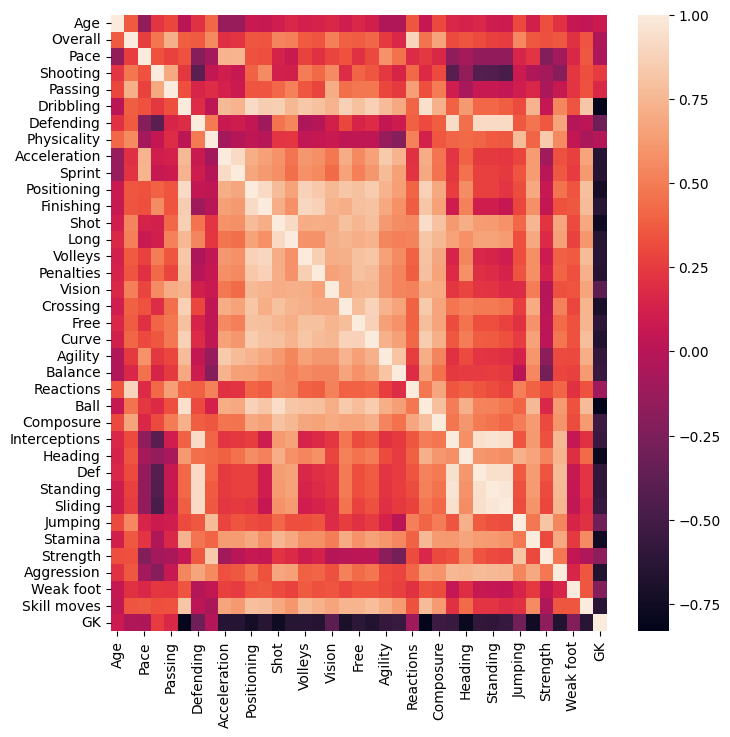

<Figure size 800x800 with 0 Axes>

In [91]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix)
plt.figure(figsize=(8,8))

**Correlation in all the data set**

There are lot of correlations in the data set.

We can even see groups of features that are correlated to each other. Here are some examples :
- 'Interceptions', 'Def', 'Standing', 'Sliding' and 'Defending' are strongly correlated.
- the square in the middle of the figure, from 'Positioning' to 'Curve'.

The following function will show us the high correlated variables in the data set (inspiraed by this notebook https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features/notebook).

In [7]:
def print_high_correlation(corr_matrix, threshold=0.9):
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            if val >= threshold:
                print(col.values[0], "and", row.values[0], ":", round(val[0][0], 2))

In [11]:
print_high_correlation(corr_matrix)

Sprint and Acceleration : 0.92
Positioning and Dribbling : 0.92
Finishing and Positioning : 0.92
Long and Shot : 0.91
Volleys and Finishing : 0.91
Ball and Dribbling : 0.95
Ball and Shot : 0.93
Interceptions and Defending : 0.93
Def and Defending : 0.92
Def and Interceptions : 0.95
Standing and Defending : 0.92
Standing and Interceptions : 0.96
Standing and Def : 0.95
Sliding and Defending : 0.92
Sliding and Interceptions : 0.95
Sliding and Def : 0.95
Sliding and Standing : 0.98


All of this means that a lot of features almost give us the same information so some of them may are quite useless and increase the complexity without any huge amelioration of the model. When we train our models, if we see huge calculation time or overfitting, we should try to remove some correlated features.

In [7]:
#to_drop = ['Ball', 'Def', 'Standing', 'Sliding'] #0.94
to_drop = ['Ball', 'Def', 'Standing', 'Sliding', 'Sprint', 'Positioning', 'Long',
           'Interceptions', 'Volleys'] 
df.drop(to_drop, axis=1)

Position  Age  Overall  Pace  Shooting  Passing  Dribbling  Defending  \
0           ST   24       91    97        90       80         93         36   
1           ST   23       91    89        93       66         79         45   
2           CM   32       91    72        88       94         86         65   
3           CF   36       90    80        87       90         96         33   
4           CF   35       90    79        88       83         87         39   
...        ...  ...      ...   ...       ...      ...        ...        ...   
17321       LM   17       54    60        50       54         54         27   
17322       CB   18       52    58        25       40         38         52   
17323       CM   23       52    60        55       53         52         49   
17324       CM   19       52    61        52       46         51         53   
17325       CB   20       52    59        42       51         51         51   

       Physicality  Acceleration  ...  Aggression  Att work rate  \
0               78            97  ...          64           High   
1               88            82  ...          87           High   
2               78            72  ...          75           High   
3               64            87  ...          44            Low   
4               78            78  ...          63         Medium   
...            ...           ...  ...         ...            ...   
17321           55            59  ...          42         Medium   
17322           55            59  ...          49         Medium   
17323           52            58  ...          51           High   
17324           59            60  ...          56         Medium   
17325           56            58  ...          49            Low   

       Def work rate  Preferred foot  Weak foot  Skill moves  Gender   GK  \
0                Low           Right          4            5       M  0.0   
1             Medium            Left          3            3       M  0.0   
2             Medium           Right          5            4       M  0.0   
3                Low            Left          4            4       M  0.0   
4             Medium           Right          4            4       M  0.0   
...              ...             ...        ...          ...     ...  ...   
17321            Low            Left          3            3       F  0.0   
17322         Medium           Right          3            2       F  0.0   
17323         Medium           Right          4            4       F  0.0   
17324         Medium            Left          3            2       F  0.0   
17325           High           Right          3            2       F  0.0   

       Top Clubs  Top Nation  
0              2           1  
1              2           0  
2              2           1  
3              0           1  
4              0           1  
...          ...         ...  
17321          0           0  
17322          0           0  
17323          0           0  
17324          0           0  
17325          0           0  

[17326 rows x 35 columns]

**Correlation with our target**

We already saw that 'GK' is strongly correlated to 'Overall' for goal keepers. What about the other features ?

In [13]:
corr_matrix['Overall'].sort_values(ascending=False)

Overall          1.000000
Reactions        0.886394
Passing          0.714892
Composure        0.670532
Physicality      0.555535
Jumping          0.549062
Shot             0.530708
Vision           0.511729
Long             0.510566
Shooting         0.475240
Ball             0.461288
Curve            0.408387
Crossing         0.387663
Dribbling        0.378612
Free             0.375605
Defending        0.369658
Age              0.369558
Volleys          0.364798
Aggression       0.359801
Stamina          0.359625
Positioning      0.354754
Finishing        0.348377
Penalties        0.346828
Heading          0.346077
Skill moves      0.343780
Strength         0.333193
Top Clubs        0.319929
Def              0.311053
Interceptions    0.310003
Standing         0.277572
Pace             0.260301
Sliding          0.251253
Agility          0.244609
Sprint           0.216722
Weak foot        0.208212
Acceleration     0.205662
Top Nation       0.189419
Balance          0.160235
GK          

In [82]:
#plotting only the top 5
interesting_features = [ 'Overall', 'Reactions', 'Passing', 'Composure', 'Physicality']

<Figure size 640x480 with 0 Axes>

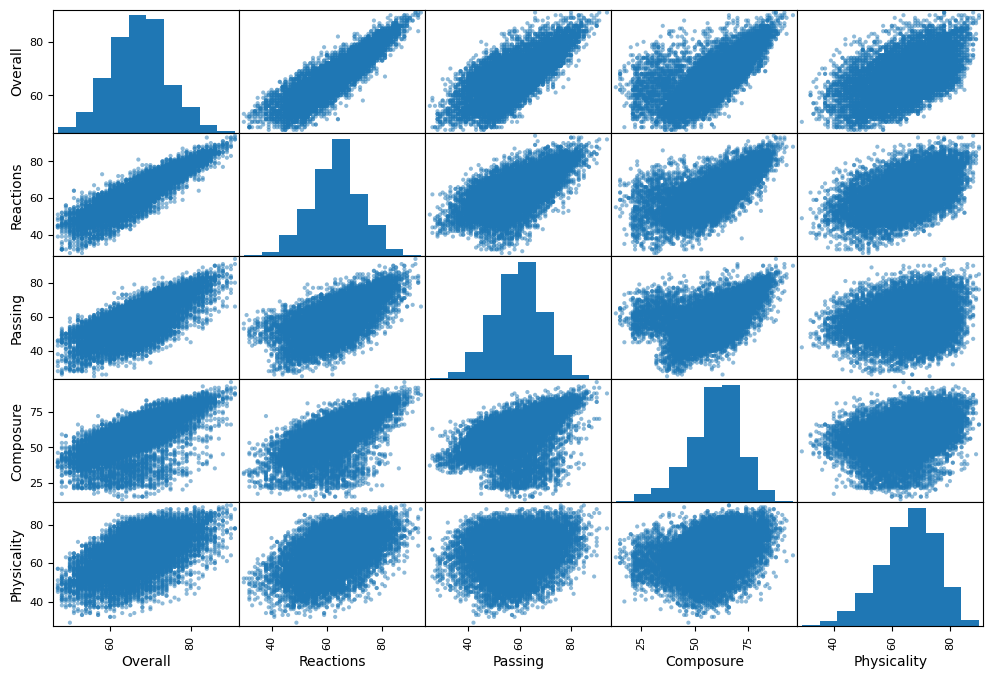

In [83]:
from pandas.plotting import scatter_matrix

plt.figure()
scatter_matrix(df[interesting_features], figsize=(12, 8))
plt.show()

With all this, we can see strong linear relationships, especially between 'Overall' and 'Reactions' (and 'GK' for goals keepers).

At this stage, choising a linear model could be a good idea (at least a good start).

# PREPOCESSING

In [8]:
X = df.drop(['Overall'], axis=1)
y = df['Overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train size :", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size : 13860
Test size : 3466


We will just scale the numerical features them with a StandardScaler.

For the categorical, we already took care of 'Nation' and 'Club'. Fot the other ones, here is what we found earlier :

- Att work rate--- ['High' 'Low' 'Medium']
- Def work rate--- ['Low' 'Medium' 'High']
- Gender---------- ['M' 'F']
- Position-------- ['ST' 'CM' 'CF' 'GK' 'RW' 'CB' 'LW' 'CDM' 'CAM' 'RM' 'LB' 'RB' 'LM' 'LWB'
 'RWB']
- Preferred foot-- ['Right' 'Left']

We will use an OrdinalEncoder to transform these features, except Position : we would rather use a OneHotEncoder instead (15 categories which are important in our opinion). For the 2 rates, we want to transform 'High' into 2, 'Medium' into 1 and 'Low' into 0 to keep the sense. 

In [9]:
transformer = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=object)),
    (OrdinalEncoder(categories=[['Low', 'Medium', 'High'], ['Low', 'Medium', 'High']]),
                  ['Att work rate', 'Def work rate']),
    (OrdinalEncoder(), ['Gender', 'Preferred foot']),
    (OneHotEncoder(handle_unknown='ignore'), ['Position'])
)

# Our first models

**Linear Regression**

As we said, we can first try a linear model such as a linear regression.

In [14]:
linear_regression = make_pipeline(transformer, LinearRegression())

cv_linear_regression = cross_val_score(linear_regression, X_train, y_train, cv=10)
cv_linear_regression

array([0.92668595, 0.93133305, 0.92727746, 0.91861075, 0.92856983,
       0.93191568, 0.9244496 , 0.91773487, 0.92756684, 0.93100056])

Really good scores for a first model. Let's try other models.

**Decision trees and Random Forest**

For models based on trees, we do not have to scale the numerical data. Here is our new ColumnTransformer :

In [17]:
transformer_tree =  make_column_transformer(
    (OrdinalEncoder(categories=[['Low', 'Medium', 'High'], ['Low', 'Medium', 'High']]),
                  ['Att work rate', 'Def work rate']),
    (OrdinalEncoder(), ['Gender', 'Preferred foot']),
    (OneHotEncoder(handle_unknown='ignore'), ['Position'])
)

In [18]:
decision_tree = make_pipeline(
    transformer_tree,
    DecisionTreeRegressor()
)

cv_decision_tree = cross_val_score(decision_tree, X_train, y_train, cv=5)
cv_decision_tree

array([0.15868869, 0.16961512, 0.13240582, 0.13103958, 0.16492427])

Really bad next to our linear regression. Maybe there is over fitting ? 

In [15]:
def plot_learning_curve(model, cv=5):
    N,train_scores, test_scores = learning_curve(model, X_train, y_train,
                                                 cv=cv,
                                                 train_sizes=np.linspace(0.1,1,10))
    plt.figure()
    plt.plot(N, train_scores.mean(axis=1), label="train score")
    plt.plot(N, test_scores.mean(axis=1), label="test score")
    plt.legend()
    plt.show()

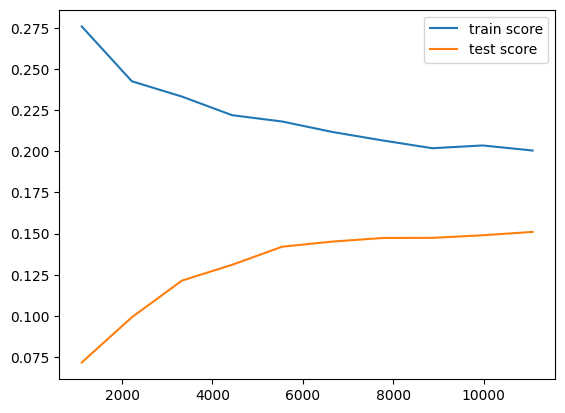

In [27]:
plot_learning_curve(decision_tree)

There is no overfitting, maybe we should try a random forest instead.

In [24]:
random_forest = make_pipeline(
    transformer_tree,
    RandomForestRegressor(n_estimators=50, max_depth=15, max_features=20)
)

cv_random_forest = cross_val_score(random_forest, X_train, y_train, cv=5)
cv_random_forest

array([0.16176837, 0.17397451, 0.14058801, 0.14060426, 0.17168484])

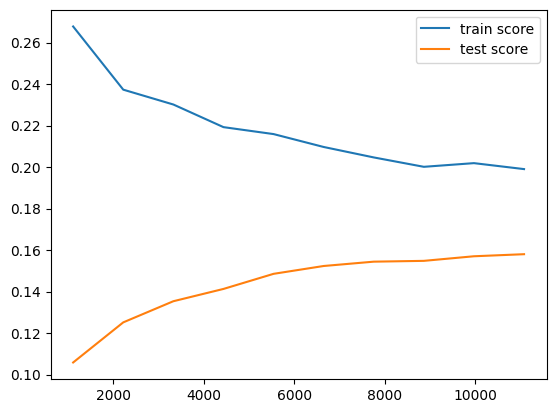

In [28]:
plot_learning_curve(random_forest)

These models are bad and a random forest takes too much time. We won't use these models anymore but we still should try ensemble model with good models (for example a AdaBoost with linear models).

**KNN**

In [17]:
knn = make_pipeline(
    transformer,
    KNeighborsRegressor()
)

cv_knn = cross_val_score(knn, X_train, y_train, cv=10)
cv_knn

array([0.92898322, 0.91970967, 0.9226975 , 0.92046475, 0.92298936,
       0.91726625, 0.9250551 , 0.92558842, 0.92920014, 0.92552595])

This model seems to be very interestig, especially if we tune it. Let's compare it to the LinearRegression our of curiosity :

In [17]:
def compare(cv1, cv2):
    scores = cv1- cv2
    n = 0
    for score in scores:
        if score > 0:
            n += 1
    return n

In [18]:
compare(cv_linear_regression, cv_knn)

9

Linear regression is almost always better then a KNN.

**SVM**

In [19]:
svr = make_pipeline(
    transformer,
    LinearSVR(max_iter=2000)
)

cv_svr = cross_val_score(svr, X_train, y_train, cv=10)
cv_svr

c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

array([0.92677195, 0.93026934, 0.92593859, 0.91830531, 0.92774451,
       0.9315281 , 0.92284251, 0.91561245, 0.92615221, 0.92994281])

In [20]:
compare(cv_knn, cv_svr), compare(cv_linear_regression, cv_svr)

(3, 9)

The linear regression is still the best model and SVR is barely better than the KNN. However, SVR takes much more time to be trained which is uncomfortable (especially if we want to tune it). 

For now, we will just work with linear models, and maybe we will tune a KNN out of curiosity.

# Models improvment

First, let's try to imrpove our linear regression : 

In [13]:
elastic_net = make_pipeline(
    transformer,
    ElasticNet()
)

param = {
    'elasticnet__alpha': [10, 1, 1e-1, 1e-2],
    'elasticnet__l1_ratio' : [1, 1e-2, 0]
}

grid_en = GridSearchCV(elastic_net, param, cv=3)
grid_en.fit(X_train, y_train)

c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+05, tolerance: 4.528e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+05, tolerance: 4.554e+01 Linear regression models with null weight for the l1 regularization term are more efficiently 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026B3B27FBE0>),
                                                                        ('ordinalencoder-1',
                                                                         OrdinalEncoder(categories=[['Low',
                                                                                                     'Medium',
                                                                                                     'High'],
                                                                                                    ['Low',
                                                                                                     'Medium',
                                                                                                     'High']]),
                                                                         ['Att '
                                                                          'work '
                                                                          'rate',
                                                                          'Def '
                                                                          'work '
                                                                          'rate']),
                                                                        ('ordinalencoder-2',
                                                                         OrdinalEncoder(),
                                                                         ['Gender',
                                                                          'Preferred '
                                                                          'foot']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Position'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [10, 1, 0.1, 0.01],
                         'elasticnet__l1_ratio': [1, 0.01, 0]})

In [14]:
grid_en.best_params_

{'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.01}

In [15]:
grid_en.best_score_

0.924490078216644

This is not better than the initial linear regression which can reach a score of 93%. Let's try to imrpove the KNN instead.

In [21]:
param_knn = {
    'kneighborsregressor__n_neighbors':[2*i+1 for i in range(25)]
}

grid_knn = GridSearchCV(knn, param_knn, cv=3)
grid_knn.fit(X_train, y_train)

ValueError: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 1.0 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 3.0416666666666665 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 5.083333333333333 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 7.125 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 9.166666666666666 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 11.208333333333332 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 13.25 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 15.291666666666666 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 17.333333333333332 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 19.375 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 21.416666666666664 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 23.458333333333332 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 25.5 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 27.541666666666664 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 29.583333333333332 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 31.624999999999996 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 33.666666666666664 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 35.70833333333333 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 37.75 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 39.791666666666664 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 41.83333333333333 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 43.875 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 45.916666666666664 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 47.95833333333333 instead.

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_neighbors' parameter of KNeighborsRegressor must be an int in the range [1, inf) or None. Got 50.0 instead.
